<font size='6'>
$\textbf{OCEAN}$ </font>

$\color{red}{\textbf{C23-PS103}} -  \color{blue}{\textbf{Machine Learning}}$


# 1. Importing Libraries

In [ ]:
#additional plug-ins
!pip install colorama
!pip install Fore

#essential libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
#import plotly.express as px
import tensorflow as tf
import gdown
import os
import sys

#additional libraries
from colorama import Fore, Back, Style
from sklearn.exceptions import DataConversionWarning
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. First Preprocessinng: Loading and Cleaning Dataset


These are global variables that contain directory paths for the further generated files, some constants for the preprocessing, and some constants for the purpose of the training.

In [ ]:
#Directory Globals
if os.path.exists('./OCEAN') == False:
  os.mkdir('./OCEAN')
RAW_DATA_DIR = './OCEAN/raw/'
TRAINABLE_DATA_DIR = './OCEAN/trainable data/'
if os.path.exists(TRAINABLE_DATA_DIR) == False:
  os.mkdir(TRAINABLE_DATA_DIR)
ANALYSIS_DATA_DIR = './OCEAN/analysis/'
if os.path.exists(ANALYSIS_DATA_DIR) == False:
  os.mkdir(ANALYSIS_DATA_DIR)
ANALYSIS_PCA_DIR = './OCEAN/analysis/PCA/'
if os.path.exists(ANALYSIS_PCA_DIR) == False:
  os.mkdir(ANALYSIS_PCA_DIR)
TRAINED_MODEL_DIR = './OCEAN/saved model/'
if os.path.exists(TRAINED_MODEL_DIR) == False:
  os.mkdir(TRAINED_MODEL_DIR)

#Preprocessing Globals
PCA_REDUCTION_DEGREE = 3
TOTAL_CLUSTERS = 15
BATCH_SIZE = 128
SHUFFLE_BUFFER = 500000

#Training Models Globals
LAST_LAYER = tf.keras.layers.Dense(TOTAL_CLUSTERS, activation = 'softmax')
INPUT_SHAPE = [10]
VAL_ACCURACY_TARGET = 0.96

#Output styling Globals
ocean_style = {"Normal": Fore.GREEN + Back.LIGHTWHITE_EX + Style.BRIGHT,
               "Error": Fore.LIGHTRED_EX  + Back.LIGHTWHITE_EX + Style.BRIGHT,
               "Warning": Fore.LIGHTMAGENTA_EX + Back.LIGHTWHITE_EX + Style.BRIGHT,
               "InStep": Fore.BLUE + Back.LIGHTWHITE_EX + Style.BRIGHT}

The $\texttt{retrieve()}$ function is called to download the dataset and the $\texttt{load()}$ function is called to load

In [ ]:
#download data from google drive (kaggle imported to google drive)
def make():
  url = 'https://drive.google.com/u/0/uc?id=11cBzLvbEtSKu6jd-VrV71q-n8cWKBWic&export=download'
  output = RAW_DATA_DIR + 'data.csv'
  print(ocean_style["Normal"] + "OCEAN: Please wait. The file is downloading.")
  gdown.download(url, output, quiet=True)
  print(ocean_style["Normal"] + "OCEAN: The raw dataset is downloaded. Proceed.")

In [ ]:
def retrieve():
    hasExisted = os.path.exists(RAW_DATA_DIR)
    if hasExisted == False:
      os.mkdir(RAW_DATA_DIR)
      make()
    else:
      if os.path.exists(RAW_DATA_DIR + 'data.csv') == False:
        print(ocean_style["Error"] + "OCEAN: 'data.csv' might have been corrupted. Creating a new one.")
        make()
      else:
        print(ocean_style["Normal"] + "OCEAN: All set. Proceed.")

In [ ]:
def load():
    print(ocean_style["Normal"] + "OCEAN: Loading the file.")
    df = pd.read_csv(RAW_DATA_DIR + 'data.csv',delimiter = '\t')
    df = df.dropna(axis=0)
    print(ocean_style["Normal"] + "OCEAN: Proceed.")
    return df.iloc[:,0:50]

The $\texttt{accustom_colomn_names()}$ function is called to rename the label to simpler conventions

In [ ]:
def accustom_column_names(original_data):
    print(ocean_style["Normal"] + "OCEAN: Accustoming the headers.")
    ocean = ['E','N','A','C','O']
    prism = ['IN', 'ES', 'CO', 'SP', 'CN']
    ocean_pos = [
        {1:1,3:2,5:3,7:4,9:5}, #E
        {1:1,3:2,5:3,6:4,7:5,8:6,9:7,10:8}, #N
        {2:1,4:2,6:3,8:4,9:5,10:6}, #A
        {1:1,3:2,5:3,7:4,9:5,10:6},#C
        {1:1,3:2,5:3,7:4,8:5,9:6,10:7} #O
    ]
    prism_pos = [
        {2:1,4:2,6:3,8:4,10:5}, #IN
        {2:1,4:2}, #ES
        {1:1,3:2,5:3,7:4}, #CO
        {2:1,4:2,6:3,8:4}, #SP
        {2:1,4:2,6:3} #CN
    ]
    
    old_cols = original_data.iloc[:,0:50].columns.to_list()
    new_cols = [prism[i] + str(prism_pos[i][j+1]) if j+1 in prism_pos[i] 
                else ocean[i] + str(ocean_pos[i][j+1]) 
                for i in range (5) for j in range(10)]
    
    dict_pair = {old_cols[i]:new_cols[i] for i in range(50)}
    
    accustomed_data = original_data.rename(columns = dict_pair, inplace = False)
    print(ocean_style["Normal"] + "OCEAN: Proceed.")
    return accustomed_data, new_cols

# 3. Second Preprocessing: PCA and K-means

The $\texttt{clump_all()}$ function is called to get the core analysis of the dataset. The original data set contains 50 dimensions. In this section, we split the original dataset into 5 different datasets and each dataset represents a specific trait. In this function, five files will be created in the $\textbf{./trainable data/}$ folder (E dataset.csv, N dataset.csv, A dataset.csv, C dataset.csv, O dataset.csv).

Each dataset has the following characteristic:
1. Has a dimension of $\left(N \times 10\right)$
Where $N$ is the total row after being cleaned in the first preprocessing.
2. Each element has the range of value $1.0 - 5.0$

Each dataset will go through dimensinality reduction (PCA) before being fed into clustering. There will be 15 clusters. We reduce the 10 dimensions data into 3 dimensions after considering the eigenvalues vector $\left(\vec{\lambda}\right)$ of the covariance matrix of each dataset ($\textbf{M} = \textbf{D}^{T} \cdot \textbf{D}$). The significant dimensions are the first tree. Hence the rests are dropped down. 

In [ ]:
#Some terms
#adt - accustomed data trait
#adtc - accustomed data trait clustered
#adts - accustomed data trait summary
#adtsbc - accustomed data trait by cluster
#adtsbcl - accustomed data trait by cluster lists

def clump_all(accustomed_data, n_clustersi, new_cols, s=1):
    print(
      ocean_style["Normal"] + "OCEAN: Generating trainable datasets."
      + ocean_style["Warning"] + " This might take a few minutes."
      + ocean_style["Error"] + " Terminating this process might reset all progress!"
    )
    
    adt = [accustomed_data.iloc[:,10*i:10*(i+1)] for i in range(5)]
    k_means_model = []
    predictions = []
    adtsbcl = []
    ocean = ['E', 'N', 'A', 'C', 'O']
    prism = ['IN', 'ES', 'CO', 'SP', 'CN']
    s = 0
    j = 35
    for i in range(5):
        with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          #PCA
          s += 1
          print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
                ". Doing dimesionality reduction for {} dataset.".format(ocean[i]))
          pca_fit = PCA(n_components=PCA_REDUCTION_DEGREE).fit_transform(adt[i])

          #K-means
          s += 1
          print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
                ". Doing K-means clustering for {} dataset.".format(ocean[i]))
          kmeans = KMeans(n_clusters=n_clustersi).fit(pca_fit)
          k_means_model.append(kmeans)
          predictions.append(kmeans.labels_)

          #K-means evaluation
          s += 1
          print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
                ". Shilhouetting the K-means.".format(ocean[i]))

          sil = metrics.silhouette_score(adt[i], kmeans.labels_, sample_size = 10000)
          print(ocean_style["Warning"] + "OCEAN: K-means for {} is finished".format(ocean[i]) +
                ". Returned silhouette score: {} ({} dataset).".format(round(sil,4), ocean[i]))
          
          #PCA visualization
          s += 1
          print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
                ". Generating PCA visualization (XY-view - {} dataset).".format(ocean[i]))
          generative_labels = ['PCA1', 'PCA2','PCA3']
          df_pca = pd.DataFrame(data=pca_fit[0:50000,:], columns=generative_labels)
          df_pca['Clusters'] = kmeans.labels_[0:50000]
          
          #xy
          plt.figure(figsize=(5,5))
          sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='tab20', alpha=0.8)
          plt.title(f'XY-view: {ocean[i]} Clusters after PCA\nSil: {format(round(sil,4))}')
          myFig = plt.gcf()
          plt.show()
          myFig.savefig(ANALYSIS_PCA_DIR + ocean[i] + ' PCA xy-view.png')
          
          #xz
          s += 1
          print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
                ". Generating PCA visualization (XZ-view - {} dataset).".format(ocean[i]))
          
          plt.figure(figsize=(5,5))
          sns.scatterplot(data=df_pca, x='PCA1', y='PCA3', hue='Clusters', palette='tab20', alpha=0.8)
          plt.title(f'XZ-view: {ocean[i]} Clusters after PCA\nSil: {format(round(sil,4))}')
          myFig = plt.gcf()
          plt.show()
          myFig.savefig(ANALYSIS_PCA_DIR + ocean[i] + ' PCA xz-view.png')

          #yz
          s += 1
          print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
                ". Generating PCA visualization (YZ-view - {} dataset).".format(ocean[i]))
          
          plt.figure(figsize=(5,5))
          sns.scatterplot(data=df_pca, x='PCA2', y='PCA3', hue='Clusters', palette='tab20', alpha=0.8)
          plt.title(f'YZ-view: {ocean[i]} Clusters after PCA\nSil: {format(round(sil,4))}')
          myFig = plt.gcf()
          plt.show()
          myFig.savefig(ANALYSIS_PCA_DIR + ocean[i] + ' PCA yz-view.png')

        adtc = pd.DataFrame(data = adt[i])
        adtc['Cluster'] = predictions[i]
        adtc.to_csv(TRAINABLE_DATA_DIR + ocean[i] + ' dataset.csv', index=False)
        
        #analysis
        s += 1
        print(ocean_style["InStep"] + "OCEAN: Arriving at step {} of {}".format(s,j) +
              ". Weighing and analyzing data for {} dataset.".format(ocean[i]))
        adts = pd.DataFrame()
        pk = [a for a in new_cols[10*i:10*(i+1)] if ocean[i] in a]
        nk = [a for a in new_cols[10*i:10*(i+1)] if prism[i] in a]
        adts[ocean[i] + '_avg'] = adt[i][pk].sum(axis=1)/len(pk)
        adts[prism[i] + '_avg'] = adt[i][nk].sum(axis=1)/len(nk)
        adts['Cluster'] = predictions[i]

        adtsbc = adts.groupby('Cluster').mean()
        get_std = adts.groupby('Cluster').std()
        
        adtsbc[ocean[i] + '_std'] = get_std[ocean[i] + '_avg']        
        adtsbc[prism[i] + '_std'] = get_std[prism[i] + '_avg']
        
        #obtain nstd for ocean
        nstd_ocean = []
        nstd_prism = []
        for n_cl in range(n_clustersi):
            cluster_avg_value_ocean = adtsbc.iloc[n_cl, 0]
            cluster_std_value_ocean = adtsbc.iloc[n_cl, 2] * s
            cluster_avg_value_prism = adtsbc.iloc[n_cl, 1]
            cluster_std_value_prism = adtsbc.iloc[n_cl, 3] * s
            filter1 = adts[adts['Cluster'] == n_cl]
            total_in_range_ocean = len(
                                    (filter1[(filter1[ocean[i] + '_avg'] > cluster_avg_value_ocean - cluster_std_value_ocean)
                                    &
                                    (filter1[ocean[i] + '_avg'] < cluster_avg_value_ocean + cluster_std_value_ocean)]
                                ).index)
            total_in_range_prism = len(
                                    (filter1[(filter1[prism[i] + '_avg'] > cluster_avg_value_prism - cluster_std_value_prism)
                                    &
                                    (filter1[prism[i] + '_avg'] < cluster_avg_value_prism + cluster_std_value_prism)]
                                ).index)
            
            nstd_ocean.append(total_in_range_ocean)
            nstd_prism.append(total_in_range_prism)
        adtsbc[ocean[i] + '_Nstd'] = nstd_ocean
        adtsbc[prism[i] + '_Nstd'] = nstd_prism

        #get total users got classified in a specific cluster
        cluster_sum = []

        for k in range(n_clustersi):
            cluster_sum.append(len(adtc[adtc['Cluster'] == k]))
            
        adtsbc['Total'] = cluster_sum
        
        #get confidence
        conf_status_ocean = []
        conf_status_prism = []
        
        for n_cl in range(n_clustersi):
            conf_status_ocean.append(round(adtsbc.iloc[i,4]/adtsbc.iloc[i,6],2))
            conf_status_prism.append(round(adtsbc.iloc[i,5]/adtsbc.iloc[i,6],2))
        adtsbc[ocean[i] + '_status'] = conf_status_ocean
        adtsbc[prism[i] + '_status'] = conf_status_prism
        adtsbc['Tier%'] = round(((adtsbc.iloc[:,0] - adtsbc.iloc[:,1]) / adtsbc.iloc[:,1])*100,2)
        
        tier = [''] * n_clustersi
        tiers = ['B', 'A', 'S', 'SS', 'SS']
        
        #Tiering OCEAN
        adtsbc_analysis = adtsbc[adtsbc['Tier%'] > 0]
        tier_np = adtsbc_analysis['Tier%'].to_numpy()
        tier_np_sorted = np.argsort(tier_np)
        tier_np_indices = np.array(adtsbc_analysis.index)
        tier_np_indices = tier_np_indices[tier_np_sorted]
        indices_len = tier_np_indices.shape[0]
        for x in range(indices_len):
            tier[tier_np_indices[x]] = tiers[int((x*100/indices_len)/25)]

        #Tiering PRISM
        adtsbc_analysis = adtsbc[adtsbc['Tier%'] < 0]
        tier_np = np.absolute(adtsbc_analysis['Tier%'].to_numpy())
        tier_np_sorted = np.argsort(tier_np)
        tier_np_indices = np.array(adtsbc_analysis.index)
        tier_np_indices = tier_np_indices[tier_np_sorted]
        indices_len = tier_np_indices.shape[0]
        for x in range(indices_len):
            tier[tier_np_indices[x]] = 'n' + tiers[int((x*100/indices_len)/25)]

        adtsbc['Tier_Status'] = tier
        adtsbcl.append(adtsbc)
        if s == 15:
          print(ocean_style["Normal"] + "OCEAN: Proceed.")
        else:
          print(ocean_style["Normal"] + "OCEAN: Proceeding to the next itteration.")
    return k_means_model, predictions, adtsbcl

In [ ]:
def analysis_save(data_input):
  print(ocean_style["Normal"] + "OCEAN: Saving files.")
  data_input[0].to_csv(ANALYSIS_DATA_DIR + "Extrovert-Introvert dataset.csv")
  data_input[1].to_csv(ANALYSIS_DATA_DIR + "Neuroticism-EMStable dataset.csv")
  data_input[2].to_csv(ANALYSIS_DATA_DIR + "Agreeable-Competitive dataset.csv")
  data_input[3].to_csv(ANALYSIS_DATA_DIR + "Conscienctious-Spontaneous dataset.csv")
  data_input[4].to_csv(ANALYSIS_DATA_DIR + "Open-Consistent dataset.csv")
  print(ocean_style["Normal"] + "OCEAN: Proceed.")

# 4. Saving All Preprocessed Data

We will run all of the functions. The final output of this run are:
1.   $\texttt{./trainable data/E dataset.csv}$
2.   $\texttt{./trainable data/N dataset.csv}$
3.   $\texttt{./trainable data/A dataset.csv}$
4. $\texttt{./trainable data/C dataset.csv}$
5. $\texttt{./trainable data/O dataset.csv}$
6. $\texttt{./analysis data/Extrovert-Introvert dataset.csv}$
7. $\texttt{./analysis data/Neuroticism-EMStable dataset.csv}$
8. $\texttt{./analysis data/Agreeable-Competitive dataset.csv}$
9. $\texttt{./analysis data/Conscienctious-Spontaneous dataset.csv}$
10. $\texttt{./analysis data/Open-Consistent dataset.csv}$

File 1-5 are the files that we will use to train 5 neural network models. File 6-10 are the file that we will use to generate the tier.





In [ ]:
#calling retrieve function
retrieve()

OCEAN: Please wait. The file is downloading.
OCEAN: The raw dataset is downloaded. Proceed.


In [ ]:
#calling load function and saving the return to original_data
original_data = load()

OCEAN: Loading the file.
OCEAN: Proceed.


In [ ]:
#altering the column names in the dataset to our conventions
accustomed_data, new_cols = accustom_column_names(original_data)

OCEAN: Accustoming the headers.
OCEAN: Proceed.


OCEAN: Generating trainable datasets. This might take a few minutes. Terminating this process might reset all progress!
OCEAN: Arriving at step 1 of 35. Doing dimesionality reduction for E dataset.
OCEAN: Arriving at step 2 of 35. Doing K-means clustering for E dataset.
OCEAN: Arriving at step 3 of 35. Shilhouetting the K-means.
OCEAN: K-means for E is finished. Returned silhouette score: 0.0899 (E dataset).
OCEAN: Arriving at step 4 of 35. Generating PCA visualization (XY-view - E dataset).


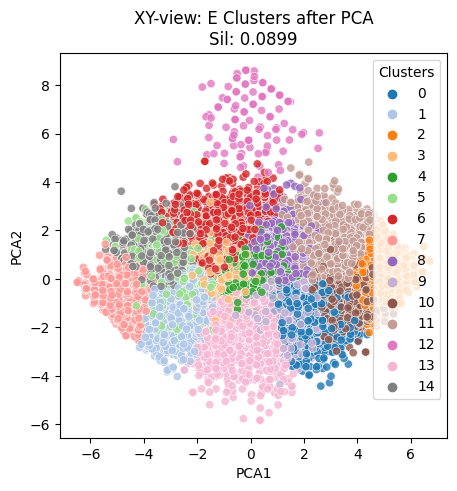

OCEAN: Arriving at step 5 of 35. Generating PCA visualization (XZ-view - E dataset).


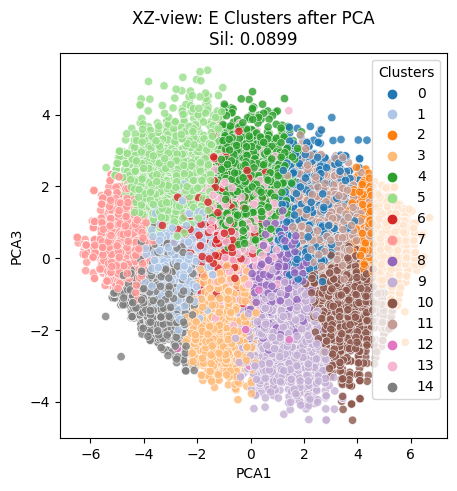

OCEAN: Arriving at step 6 of 35. Generating PCA visualization (YZ-view - E dataset).


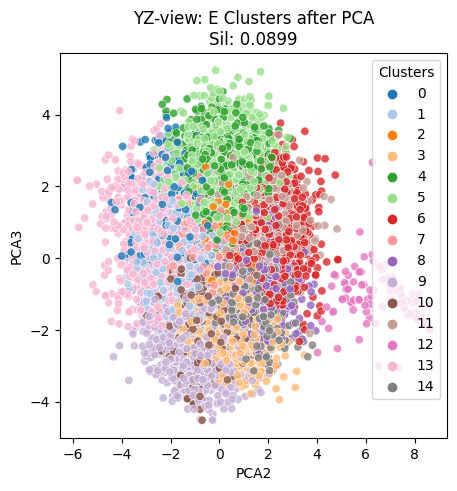

OCEAN: Arriving at step 7 of 35. Weighing and analyzing data for E dataset.
OCEAN: Proceeding to the next itteration.
OCEAN: Arriving at step 8 of 35. Doing dimesionality reduction for N dataset.
OCEAN: Arriving at step 9 of 35. Doing K-means clustering for N dataset.
OCEAN: Arriving at step 10 of 35. Shilhouetting the K-means.
OCEAN: K-means for N is finished. Returned silhouette score: 0.0824 (N dataset).
OCEAN: Arriving at step 11 of 35. Generating PCA visualization (XY-view - N dataset).


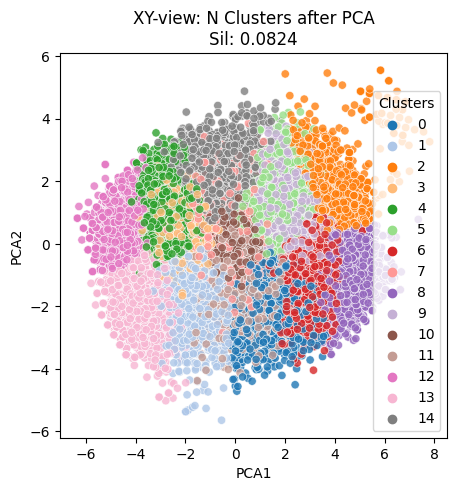

OCEAN: Arriving at step 12 of 35. Generating PCA visualization (XZ-view - N dataset).


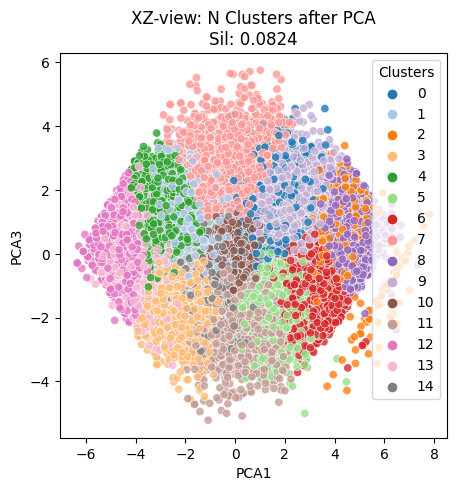

OCEAN: Arriving at step 13 of 35. Generating PCA visualization (YZ-view - N dataset).


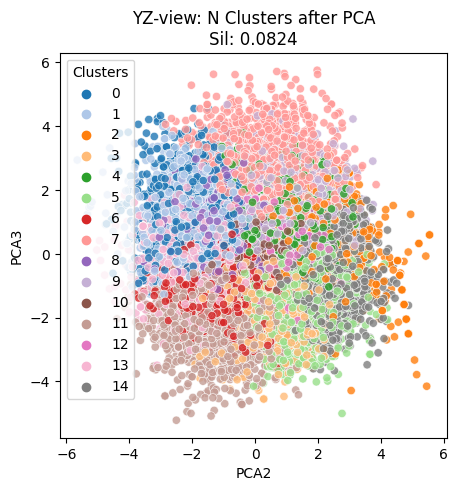

OCEAN: Arriving at step 14 of 35. Weighing and analyzing data for N dataset.
OCEAN: Proceeding to the next itteration.
OCEAN: Arriving at step 15 of 35. Doing dimesionality reduction for A dataset.
OCEAN: Arriving at step 16 of 35. Doing K-means clustering for A dataset.
OCEAN: Arriving at step 17 of 35. Shilhouetting the K-means.
OCEAN: K-means for A is finished. Returned silhouette score: 0.0988 (A dataset).
OCEAN: Arriving at step 18 of 35. Generating PCA visualization (XY-view - A dataset).


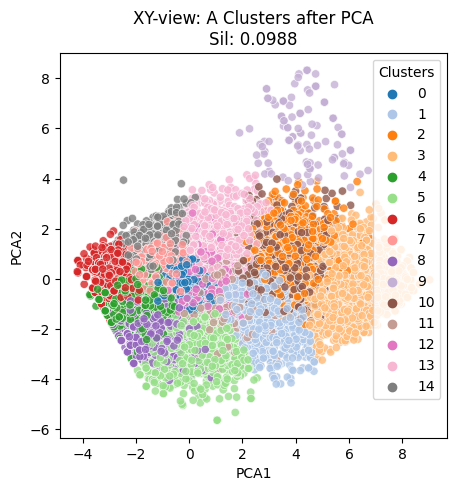

OCEAN: Arriving at step 19 of 35. Generating PCA visualization (XZ-view - A dataset).


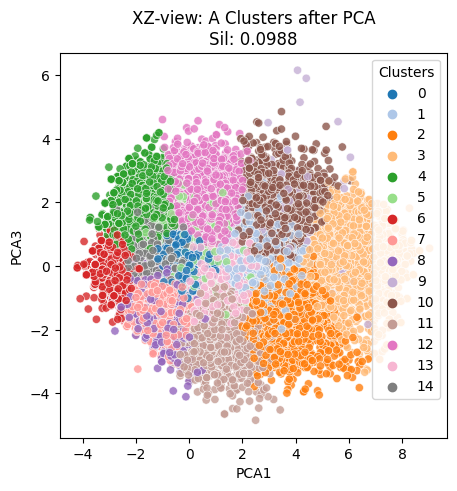

OCEAN: Arriving at step 20 of 35. Generating PCA visualization (YZ-view - A dataset).


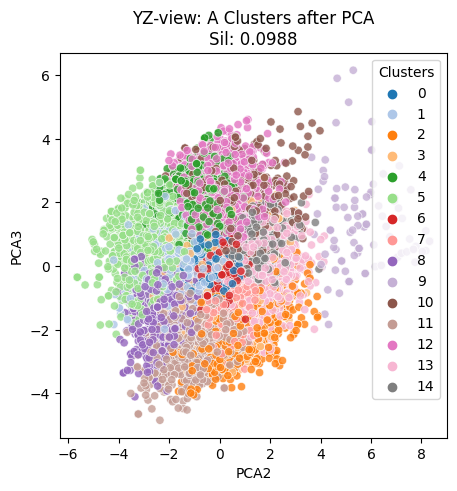

OCEAN: Arriving at step 21 of 35. Weighing and analyzing data for A dataset.
OCEAN: Proceeding to the next itteration.
OCEAN: Arriving at step 22 of 35. Doing dimesionality reduction for C dataset.
OCEAN: Arriving at step 23 of 35. Doing K-means clustering for C dataset.
OCEAN: Arriving at step 24 of 35. Shilhouetting the K-means.
OCEAN: K-means for C is finished. Returned silhouette score: 0.073 (C dataset).
OCEAN: Arriving at step 25 of 35. Generating PCA visualization (XY-view - C dataset).


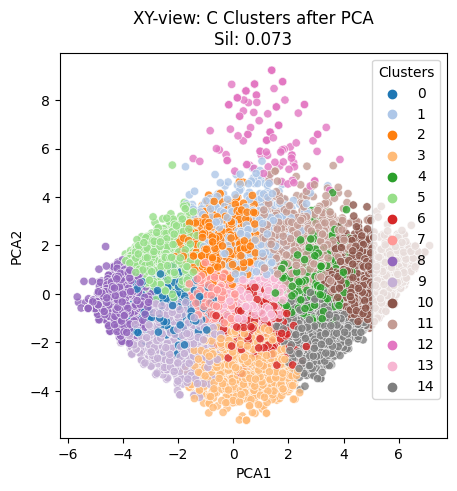

OCEAN: Arriving at step 26 of 35. Generating PCA visualization (XZ-view - C dataset).


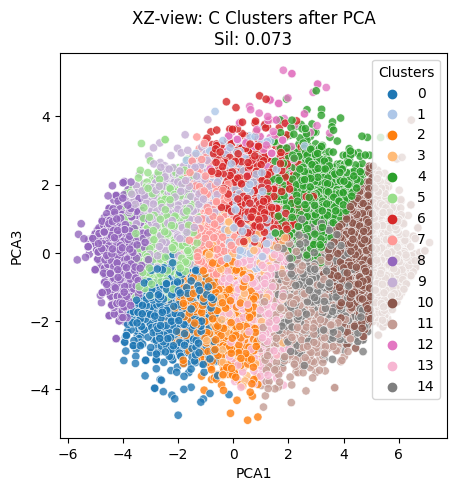

OCEAN: Arriving at step 27 of 35. Generating PCA visualization (YZ-view - C dataset).


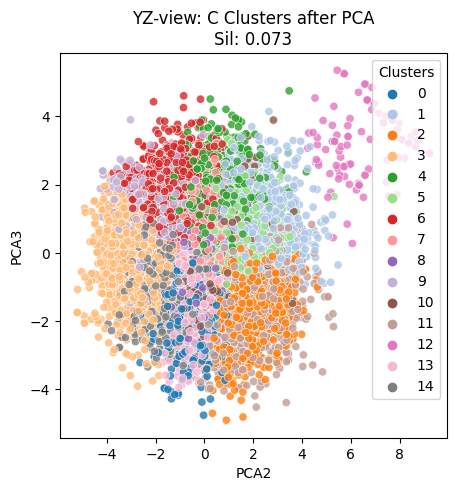

OCEAN: Arriving at step 28 of 35. Weighing and analyzing data for C dataset.
OCEAN: Proceeding to the next itteration.
OCEAN: Arriving at step 29 of 35. Doing dimesionality reduction for O dataset.
OCEAN: Arriving at step 30 of 35. Doing K-means clustering for O dataset.
OCEAN: Arriving at step 31 of 35. Shilhouetting the K-means.
OCEAN: K-means for O is finished. Returned silhouette score: 0.0828 (O dataset).
OCEAN: Arriving at step 32 of 35. Generating PCA visualization (XY-view - O dataset).


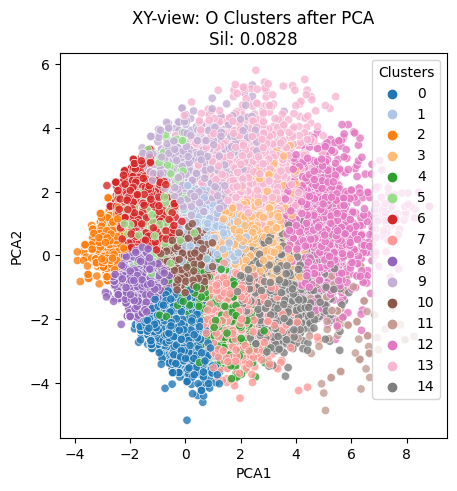

OCEAN: Arriving at step 33 of 35. Generating PCA visualization (XZ-view - O dataset).


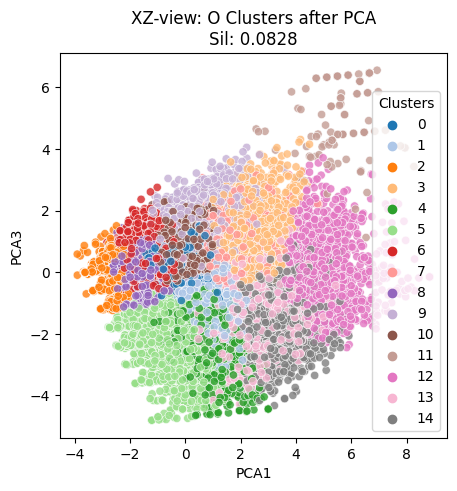

OCEAN: Arriving at step 34 of 35. Generating PCA visualization (YZ-view - O dataset).


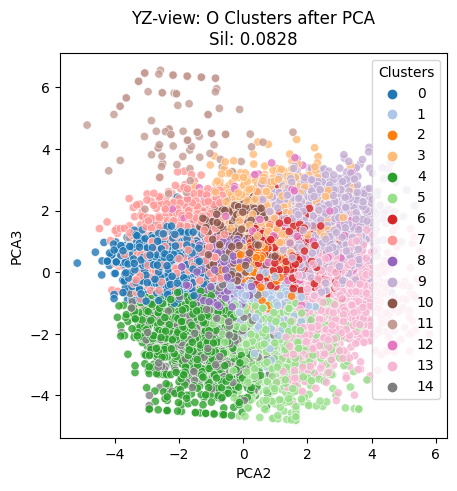

OCEAN: Arriving at step 35 of 35. Weighing and analyzing data for O dataset.
OCEAN: Proceeding to the next itteration.


In [ ]:
#analysis the data
k_model, predictions, accustomed_data_summary = clump_all(accustomed_data, TOTAL_CLUSTERS, new_cols,2)

In [ ]:
#saving all of the analysis to 5 files. 
analysis_save(accustomed_data_summary)

OCEAN: Saving files.
OCEAN: Proceed.


# 5. Loading Clean Data

## Load the processed data to train the 5 neural networks. The function $\texttt{load_data()}$ is called to generate the features (array of 5, each containing numpy array $\left(N \times 10\right)$ of each OCEAN) and to generate labels (array of 5, each containing numpy array $\left(N \times 1\right)$ of each OCEAN)

In [ ]:
####from gdrive [don't forget to run the first two cells in section 1 and 2 to load the globals
####and libraries]
ocean = ['E', 'N', 'A', 'C', 'O']
links = [
    'https://drive.google.com/uc?export=download&id=19FCB_zENpAkjVw-3ggUUjhiqVwmQAJzv', #E
    'https://drive.google.com/uc?export=download&id=15IJH7AjkKXU6u2PRuNdMDVytS7s9b1Cp', #N
    'https://drive.google.com/uc?export=download&id=1YuSinmIO1tJs4pXRx7kstEdn1aCXesN3', #A
    'https://drive.google.com/uc?export=download&id=1byK0pBRnicEElsEdfHewNiqeO8AInqNY', #C
    'https://drive.google.com/uc?export=download&id=1f7X0_vDVSKmUAhZa0RekqgtzyJlue9F7', #O
]
for i in range(5):
  output = TRAINABLE_DATA_DIR + ocean[i] + ' dataset.csv'
  gdown.download(links[i], output, quiet=False)

#load models (.h5)
links = [
    'https://drive.google.com/uc?export=download&id=1PIWLlzPn30Q5sRUidNcEWs07NzWqeP3F', #E
    '', #N
    '', #A
    '', #C
    '', #O
]

NameError: ignored

In [ ]:
def load_data():
  print(ocean_style["Normal"] + "OCEAN: Loading the data.")
  ocean_features = []
  ocean_labels = []
  ocean = ['E', 'N', 'A', 'C', 'O']

  for i in range(5):
    temp_df = pd.read_csv(TRAINABLE_DATA_DIR + ocean[i] + ' dataset.csv')
    temp_features_np = temp_df.iloc[:,0:10]
    temp_label_np = temp_df.iloc[:,10]

    ocean_features.append(temp_features_np)
    ocean_labels.append(temp_label_np)
    
  print(ocean_style["Normal"] + "OCEAN: Proceed.")
  return np.array(ocean_features), np.array(ocean_labels)

Now we split the data using $\texttt{split_data()}$ funcion. The major part is fed to the training and the minor part is fed to the validation.

In [ ]:
def split_data(percent_of_split, ocean_features, ocean_labels):
  print(ocean_style["Normal"] + "OCEAN: Splitting the data.")
  n = int(ocean_features[0].shape[0] * percent_of_split)

  train_ocean_features = []
  train_ocean_labels = []

  validation_ocean_features = []
  validation_ocean_labels = []

  train_ocean_ds = []
  val_ocean_ds = []

  for i in range(5):
    #creating dataset
    train_features_ds = ocean_features[i,0:n,:]
    train_labels_ds = np.expand_dims(ocean_labels[i,0:n], axis=1)
    train_ocean_ds.append(
        tf.data.Dataset.from_tensor_slices((train_features_ds, train_labels_ds))
    )

    val_features_ds = ocean_features[i,n:,:]
    val_labels_ds = np.expand_dims(ocean_labels[i,n:], axis=1)
    val_ocean_ds.append(
        tf.data.Dataset.from_tensor_slices((val_features_ds, val_labels_ds))
    )
    
  print(ocean_style["Normal"] + "OCEAN: Proceed.")
  return train_ocean_ds, val_ocean_ds

We can shuffle the dataset randomly via $\texttt{shuffle()}$ function below.

In [ ]:
def shuffle(ocean_train_ds, ocean_validation_ds):
  print(ocean_style["Normal"] + "OCEAN: Shuffling the data.")
  shuffled_train_ds = []
  shuffled_val_ds = []

  #shuffling dataset
  for i in range(5):
    shuffled_train_ds.append(ocean_train_ds[i].shuffle(SHUFFLE_BUFFER))
    shuffled_val_ds.append(ocean_validation_ds[i].shuffle(SHUFFLE_BUFFER))
  print(ocean_style["Normal"] + "OCEAN: Proceed.")
  return shuffled_train_ds, shuffled_val_ds

The following function, $\texttt{naming_standardize()}$, is only doing favor for our convinience in the training. For instance, instead of typing $\texttt{train_ds[3]}$, it's much more sensible if we type $\texttt{train_ds['C']}$

In [ ]:
def naming_standardize(train_ds, validation_ds):
  print(ocean_style["Normal"] + "OCEAN: Renaming the variables.")
  ocean = ['E', 'N', 'A', 'C', 'O']
  train_ds = {ocean[i]:train_ds[i] for i in range(5)}
  val_ds = {ocean[i]:validation_ds[i] for i in range(5)}
  print(ocean_style["Normal"] + "OCEAN: Proceed.")
  return train_ds, val_ds

We want to batch the data to gain more efficiency in the training. We will call $\texttt{make_batch()}$

In [ ]:
def make_batch(train_ds, validation_ds):
  print(ocean_style["Normal"] + "OCEAN: Batching the data.")
  ocean = ['E', 'N', 'A', 'C', 'O']

  batched_train_ds = {i:0 for i in ocean}
  batched_val_ds = {i:0 for i in ocean}

  for j in ocean:
    batched_train_ds[j] = train_ds[j].batch(BATCH_SIZE)
    batched_val_ds[j] =  validation_ds[j].batch(BATCH_SIZE)
  print(ocean_style["Normal"] + "OCEAN: Proceed. Everything is all set :D!")
  return batched_train_ds, batched_val_ds

And finally, $\texttt{check()}$ function will be called to review our data whether it meets the criteria.

In [ ]:
def tell_shape(ds):
    size_rows = len(ds)
    size_cols = ds.element_spec[0].shape[0]
    return str(size_rows) + ' x ' + str(size_cols)

def check(train_ds, val_ds):
  print(ocean_style["Normal"] + "OCEAN: This is what we got:")
  ocean = ['E', 'N', 'A', 'C', 'O']
  passed = 0
  
  for i in ocean:
    print(ocean_style["Error"] + f"\t{i}=>")
    print(ocean_style["Warning"] + f"\t-Training Data Shape: {tell_shape(train_ds[i])}")
    print(ocean_style["Warning"] + f"\t-Validation Data Shape: {tell_shape(val_ds[i])}")


This is just a function to execute all of the functions.

In [ ]:
def load_data_all_in_one_run():
  #load the data
  features, labels = load_data()

  #split the data
  train_ds, validation_ds = split_data(0.8, features, labels)

  #shuffle the data
  train_ds, validation_ds = shuffle(train_ds, validation_ds)

  #standardize the name of the data (for example: instead of train_ds[0], it is 
  #more sensible if it's altered to train_ds['E'])
  train_ds, validation_ds = naming_standardize(train_ds, validation_ds)

  #show all data dimensions
  check(train_ds, validation_ds)

  #batch the data
  train_ds, validation_ds = make_batch(train_ds, validation_ds)
  return train_ds, validation_ds

All set, now run these functions to get the trainable data in one execution

In [ ]:
#run
train_ds, validation_ds = load_data_all_in_one_run()

OCEAN: Loading the data.
OCEAN: Proceed.
OCEAN: Splitting the data.
OCEAN: Proceed.
OCEAN: Shuffling the data.
OCEAN: Proceed.
OCEAN: Renaming the variables.
OCEAN: Proceed.
OCEAN: This is what we got:
	E=>
	-Training Data Shape: 809640 x 10
	-Validation Data Shape: 202410 x 10
	N=>
	-Training Data Shape: 809640 x 10
	-Validation Data Shape: 202410 x 10
	A=>
	-Training Data Shape: 809640 x 10
	-Validation Data Shape: 202410 x 10
	C=>
	-Training Data Shape: 809640 x 10
	-Validation Data Shape: 202410 x 10
	O=>
	-Training Data Shape: 809640 x 10
	-Validation Data Shape: 202410 x 10
OCEAN: Batching the data.
OCEAN: Proceed. Everything is all set :D!


# 6. Model


<font size=4>$\color{red}{\text{If validaiton accuracy is much higher than training accuracy by over $5\%$}}$, reshuffle the dataset: rerun $\texttt{load_data_all_in_one_run()}$. It could be due to the uneven distribution in validation dataset (monotonous data that resembles the training data) </font>

In [ ]:
ocean_models = {"E":0, "N":0, "A":0, "C":0, "O":0}
histories = {"E":0, "N":0, "A":0, "C":0, "O":0}

In [ ]:
#callback
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.94 and logs.get('accuracy') > 0.94):
            self.model.stop_training = True

<font size=5> Training E </font>

In [ ]:
#model
tf.random.set_seed(1234)
ocean_models['E'] = tf.keras.models.Sequential (
    [
        tf.keras.layers.Dense(16, activation = 'relu', input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        LAST_LAYER
    ]
)

#compile
ocean_models['E'].compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics = ['accuracy'] 
)

In [ ]:
#fit
n_epochs = 30

#terminator if val_acc reach >= 96%
theCall = myCallBack()

#step rate. the larger the epoch the smaller the step.
#step_rate = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4)

histories['E'] = ocean_models['E'].fit(
    x = train_ds['E'],
    batch_size = BATCH_SIZE, #128 is very ideal for our dataset
    epochs = n_epochs,
    validation_data = validation_ds['E'],
    callbacks = [theCall] #,step_rate]
)

Epoch 1/30
6326/6326 [==============================] - 28s 4ms/step - loss: 0.2270 - accuracy: 0.9131 - val_loss: 0.0970 - val_accuracy: 0.9629
Epoch 2/30
6326/6326 [==============================] - 25s 4ms/step - loss: 0.1010 - accuracy: 0.9585 - val_loss: 0.1023 - val_accuracy: 0.9573


In [ ]:
#save
ocean_models['E'].save(TRAINED_MODEL_DIR + 'E model.h5')


<font size=5> Training N </font>

In [ ]:
#model
#tf.random.set_seed(1234)
ocean_models['N'] = tf.keras.models.Sequential (
    [
        tf.keras.layers.Dense(20, activation = 'relu', input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        LAST_LAYER
    ]
)

#compile
ocean_models['N'].compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3),
    metrics = ['accuracy'] 
)

In [ ]:
#fit
n_epochs = 30

#terminator if val_acc reach >= 96%
theCall = myCallBack()

#step rate. the larger the epoch the smaller the step.
#step_rate = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4)

histories['N'] = ocean_models['N'].fit(
    x = train_ds['N'],
    batch_size = BATCH_SIZE, #128 is very ideal for our dataset
    epochs = n_epochs,
    validation_data = validation_ds['N'],
    callbacks = [theCall] #,step_rate]
)

Epoch 1/30
6326/6326 [==============================] - 25s 4ms/step - loss: 0.2218 - accuracy: 0.9124 - val_loss: 0.0925 - val_accuracy: 0.9641
Epoch 2/30
6326/6326 [==============================] - 24s 4ms/step - loss: 0.1256 - accuracy: 0.9479 - val_loss: 0.0958 - val_accuracy: 0.9597
Epoch 3/30
6326/6326 [==============================] - 28s 4ms/step - loss: 0.1111 - accuracy: 0.9537 - val_loss: 0.0951 - val_accuracy: 0.9600
Epoch 4/30
6326/6326 [==============================] - 27s 4ms/step - loss: 0.1021 - accuracy: 0.9576 - val_loss: 0.0830 - val_accuracy: 0.9656
Epoch 5/30
6326/6326 [==============================] - 26s 4ms/step - loss: 0.0966 - accuracy: 0.9598 - val_loss: 0.0863 - val_accuracy: 0.9616
Epoch 6/30
6326/6326 [==============================] - 27s 4ms/step - loss: 0.0942 - accuracy: 0.9609 - val_loss: 0.1002 - val_accuracy: 0.9545
Epoch 7/30
6326/6326 [==============================] - 25s 4ms/step - loss: 0.0864 - accuracy: 0.9636 - val_loss: 0.1421 - val_ac

In [ ]:
 #save
ocean_models['N'].save(TRAINED_MODEL_DIR + 'N model.h5')

In [ ]:
#test (delete later)
N_model_load = tf.keras.saving.load_model('N model.h5')
N_model_load.predict([[1,2,3,4,5,1,2,3,4,5]])

1/1 [==============================] - 0s 212ms/step


array([[1.2343176e-06, 1.0136389e-05, 1.6926175e-28, 1.4844449e-17,
        1.0630549e-12, 1.5109304e-10, 2.1910417e-16, 5.0417191e-07,
        7.7891389e-22, 2.9323299e-08, 9.9998808e-01, 4.3830807e-12,
        0.0000000e+00, 1.4459662e-30, 2.9411181e-12]], dtype=float32)

[9]

<font size=5> Training A </font>

In [ ]:
#model
#tf.random.set_seed(1234)
ocean_models['A'] = tf.keras.models.Sequential (
    [
        tf.keras.layers.Dense(20, activation = 'relu', input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        LAST_LAYER
    ]
)

#compile
ocean_models['A'].compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3),
    metrics = ['accuracy'] 
)

In [ ]:
#fit
n_epochs = 30

#terminator if val_acc reach >= 96%
theCall = myCallBack()

#step rate. the larger the epoch the smaller the step.
#step_rate = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4)

histories['A'] = ocean_models['A'].fit(
    x = train_ds['A'],
    batch_size = BATCH_SIZE, #128 is very ideal for our dataset
    epochs = n_epochs,
    validation_data = validation_ds['A'],
    callbacks = [theCall] #,step_rate]
)

Epoch 1/30
6326/6326 [==============================] - 26s 4ms/step - loss: 0.2011 - accuracy: 0.9198 - val_loss: 0.1791 - val_accuracy: 0.9241
Epoch 2/30
6326/6326 [==============================] - 21s 3ms/step - loss: 0.1188 - accuracy: 0.9507 - val_loss: 0.0672 - val_accuracy: 0.9760


In [ ]:
 #save
ocean_models['A'].save(TRAINED_MODEL_DIR + 'A model.h5')

<font size=5> Training C </font>

In [ ]:
#model
ocean_models['C'] = tf.keras.models.Sequential (
    [
        tf.keras.layers.Dense(16, activation = 'relu', input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        
        LAST_LAYER
    ]
)

#compile
ocean_models['C'].compile( 
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ['accuracy'] )

In [ ]:
#fit
histories['C']=ocean_models['C'].fit(
    x = train_ds['C'],
    batch_size = BATCH_SIZE, #128 is very ideal for our dataset
    epochs = 10,
    validation_data = validation_ds['C'] #,
   # callbacks = [theCall ,step_rate]
    
)

Epoch 1/10
6326/6326 [==============================] - 28s 4ms/step - loss: 0.7365 - accuracy: 0.7323 - val_loss: 0.3966 - val_accuracy: 0.8607
Epoch 2/10
6326/6326 [==============================] - 26s 4ms/step - loss: 0.2974 - accuracy: 0.9078 - val_loss: 0.2211 - val_accuracy: 0.9388
Epoch 3/10
6326/6326 [==============================] - 28s 4ms/step - loss: 0.1884 - accuracy: 0.9510 - val_loss: 0.1602 - val_accuracy: 0.9577
Epoch 4/10
6326/6326 [==============================] - 26s 4ms/step - loss: 0.1441 - accuracy: 0.9651 - val_loss: 0.1256 - val_accuracy: 0.9726
Epoch 5/10
6326/6326 [==============================] - 27s 4ms/step - loss: 0.1194 - accuracy: 0.9717 - val_loss: 0.1129 - val_accuracy: 0.9683
Epoch 6/10
6326/6326 [==============================] - 30s 4ms/step - loss: 0.1036 - accuracy: 0.9754 - val_loss: 0.0983 - val_accuracy: 0.9738
Epoch 7/10
6326/6326 [==============================] - 26s 4ms/step - loss: 0.0927 - accuracy: 0.9778 - val_loss: 0.0879 - val_ac

In [ ]:
#save
ocean_models['C'].save(TRAINED_MODEL_DIR+'C model.h5')


<font size=5> Training O </font>

In [ ]:
#model
ocean_models['O']=tf.keras.models.Sequential([
    tf.keras.layers.Dense(16,activation='relu',input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    LAST_LAYER
])
ocean_models['O'].compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=8e-5),
    metrics = ['accuracy']
)

In [ ]:
#fit
tf.random.set_seed(1234)
histories['O']=ocean_models['O'].fit(
    x = train_ds['O'],
    batch_size = BATCH_SIZE, #128 is very ideal for our dataset
    epochs = 10,
    validation_data = validation_ds['O'] #,
   # callbacks = [theCall ,step_rate]
    
)

Epoch 1/10
6326/6326 [==============================] - 31s 5ms/step - loss: 1.1790 - accuracy: 0.6556 - val_loss: 0.4616 - val_accuracy: 0.8415
Epoch 2/10
6326/6326 [==============================] - 30s 4ms/step - loss: 0.3705 - accuracy: 0.8757 - val_loss: 0.2868 - val_accuracy: 0.9124
Epoch 3/10
6326/6326 [==============================] - 31s 5ms/step - loss: 0.2486 - accuracy: 0.9260 - val_loss: 0.2078 - val_accuracy: 0.9412
Epoch 4/10
6326/6326 [==============================] - 28s 4ms/step - loss: 0.1909 - accuracy: 0.9483 - val_loss: 0.1692 - val_accuracy: 0.9557
Epoch 5/10
6326/6326 [==============================] - 30s 4ms/step - loss: 0.1577 - accuracy: 0.9600 - val_loss: 0.1423 - val_accuracy: 0.9662
Epoch 6/10
6326/6326 [==============================] - 29s 4ms/step - loss: 0.1356 - accuracy: 0.9666 - val_loss: 0.1261 - val_accuracy: 0.9702
Epoch 7/10
6326/6326 [==============================] - 41s 6ms/step - loss: 0.1201 - accuracy: 0.9709 - val_loss: 0.1102 - val_ac

In [ ]:
#save
ocean_models['O'].save(TRAINED_MODEL_DIR+'O model.h5')

# 7. Model Evaluation

Histogram () input:
1. model is the variable assigned by function $\color{blue}{\text{model.fit()}}$
2. train_metrics is $\text{metrics from training} $ example : $\color{blue}{'loss'} $ or $\color{blue}{'acc'}$
3. epoch range is $\text{mutiple of epoch of training or validation}$. 
example: $\color{blue}{\text{epoch_range=10 the Xlabel become 0,10,20,30,...,n}}$.

example to use : histogram(histories['E'],'accuracy',1)

In [ ]:
print(histories['E'].history.keys())

In [ ]:
def histogram(model, train_metrics,epoch_range):
  tr=model.history[train_metrics]
  val = model.history['val_'+train_metrics]
  epochs=[*range(int(len(tr)/epoch_range))]
  plt.plot(epochs,tr,'r')
  plt.plot(epochs,val,'b')
  title='Training and validation '+train_metrics
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel(train_metrics)
  plt.legend([train_metrics,'validation '+train_metrics])
  plt.show()



Histogram E

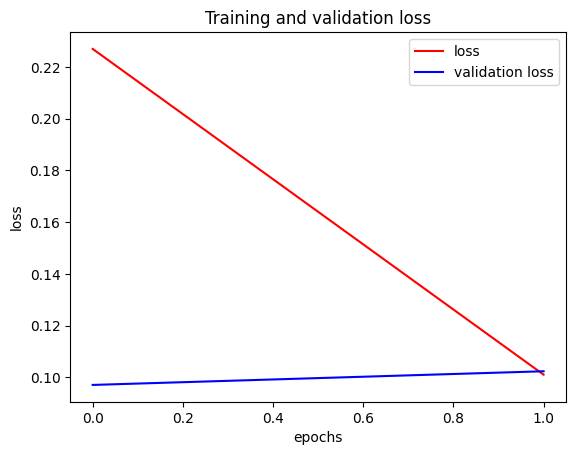

In [ ]:
#loss
histogram(histories['E'], 'loss', 1)

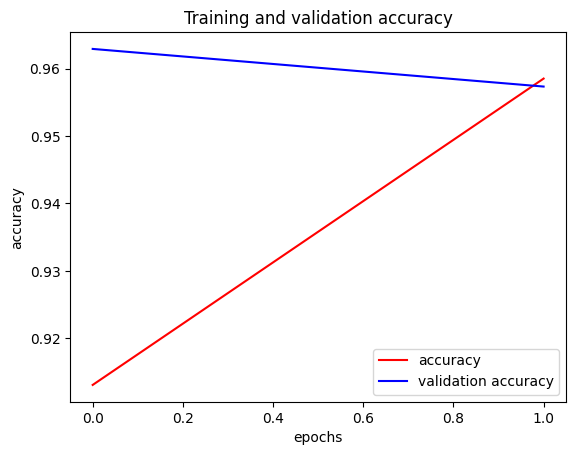

In [ ]:
#accuracy
histogram(histories['E'], 'accuracy', 1)

Histogram N

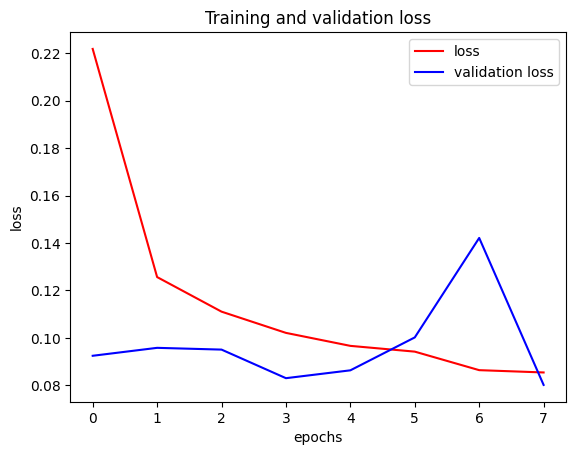

In [ ]:
#loss
histogram(histories['N'], 'loss', 1)

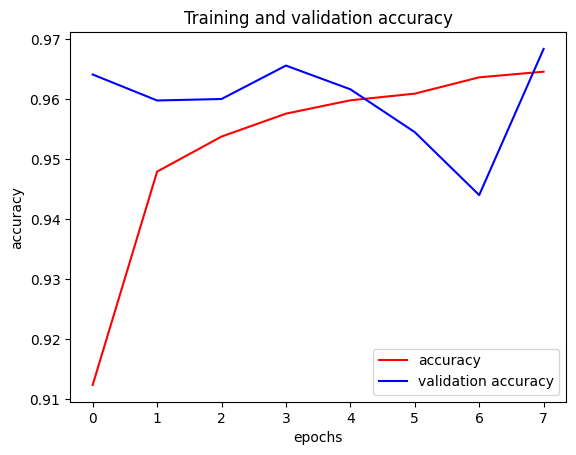

In [ ]:
#accuracy
histogram(histories['N'], 'accuracy', 1)

Histogram A

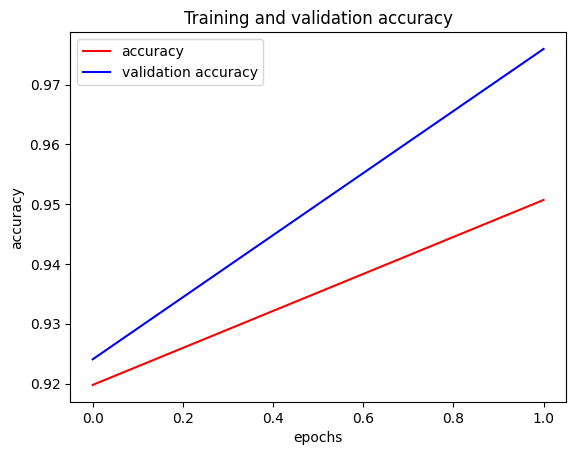

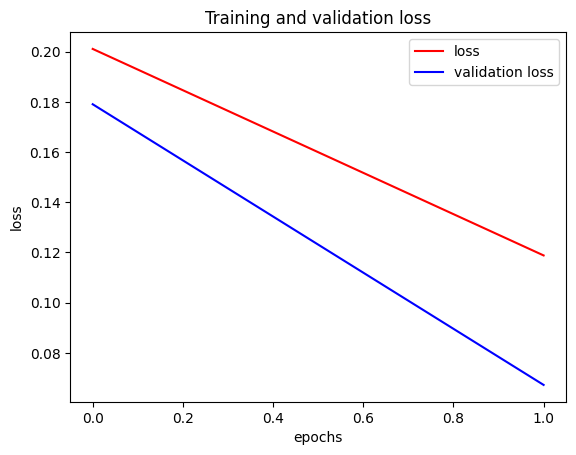

In [ ]:
# accuracy
histogram(histories['A'], 'accuracy', 1)
#loss
histogram(histories['A'], 'loss', 1)

Histogram C

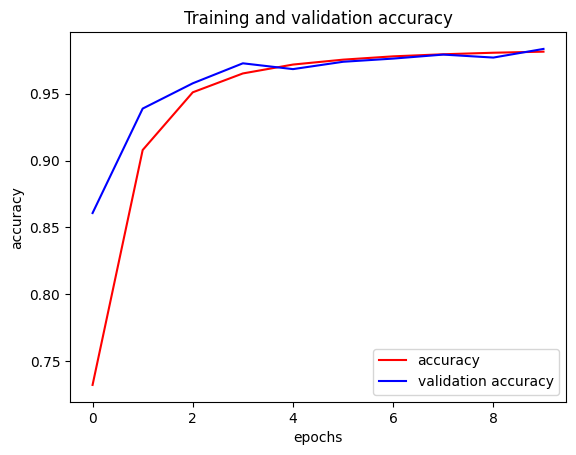

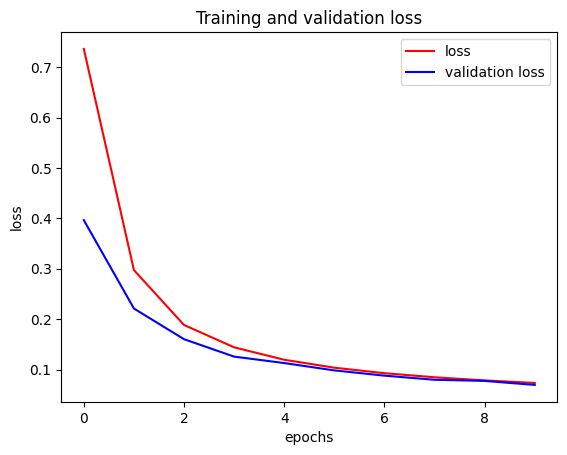

In [ ]:
# accuracy
histogram(histories['C'], 'accuracy', 1)
#loss
histogram(histories['C'], 'loss', 1)

Histogram O

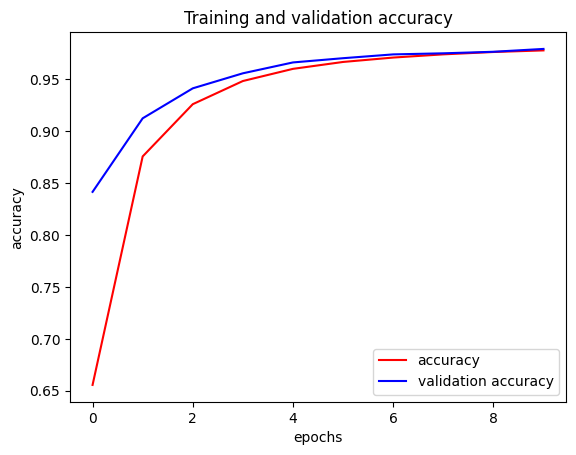

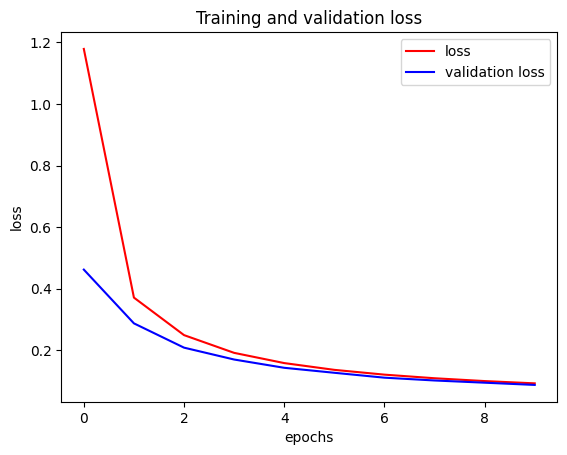

In [ ]:
# accuracy
histogram(histories['O'], 'accuracy', 1)
#loss
histogram(histories['O'], 'loss', 1)

# 8. Model Deploy

In [ ]:
#TFjs
import tensorflowjs as tfjs


In [ ]:
  tfjs.converters.save_keras_model(model, tfjs_target_dir)

# 9. ML Simulation (Input->Output) and Conventions

In this section, we will evaluate the precision of our model by using real test data. In this section, we will also define the output conventions.

Some terms:

$\texttt{SS}$: Absolutely O/C/E/A/N

$\texttt{S}$: Very O/C/E/A/N

$\texttt{A}$: O/C/E/A/N

$\texttt{B}$: Somewhat O/C/E/A/N

Example: 
1. Someone has $\texttt{SS}$ for $\texttt{'O'}$. That means they are 'absolutely' $\color{blue}{\text{open}}$ person. 
2. Someone has $\texttt{B}$ for $\texttt{'E'}$. That means they are 'somewhat' $\color{blue}{\text{extraverted}}$.

$\texttt{nSS}$: Absolutely **NOT** O/C/E/A/N

$\texttt{nS}$: Very **NOT** O/C/E/A/N

$\texttt{nA}$: **NOT** O/C/E/A/N

$\texttt{nB}$: Somewhat **NOT** O/C/E/A/N

Example:
1. Someone has $\texttt{nS}$ for $\texttt{'C'}$. That means they are $\color{red}{\text{NOT}}$ 'very' conscientious person. 
2. Someone has $\texttt{nB}$ for $\texttt{'E'}$. That means they are 'somewhat' $\color{red}{\text{NOT}}$ $\color{blue}{\text{extraverted}}$.

here link to example output from models in bar graph: [teks link](https://colab.research.google.com/drive/1GyPvxUSjFuA9nxrEqoRYnhGXzGkZ5n4c?usp=sharing)